# **Tutorial 2: Reconstructing Past Changes in Ocean Climate**
**Week 1, Day 4, Paleoclimate**

**Content creators:** Sloane Garelick

**Content reviewers:** Agustina Pesce, Zahra Khodakaramimaghsoud

**Content editors:** Agustina Pesce, Zahra Khodakaramimaghsoud

**Production editors:** TBD

**Our 2023 Sponsors:** TBD

###**Code and Data Sources**

Code for this tutorial is based on existing notebooks from LinkedEarth that uses the `Pyleoclim` package to [assess variability in the El Nino](https://github.com/LinkedEarth/PyleoTutorials/blob/main/notebooks/L0_a_quickstart.ipynb). 

Data from the following sources are used in this tutorial:


*   Kaplan, A., M. Cane, Y. Kushnir, A. Clement, M. Blumenthal, and B. Rajagopalan, Analyses of global sea surface temperature 1856-1991, Journal of Geophysical Research, 103, 18,567-18,589, 1998
*   Pre-processed data form Kaplan et al. (1998) from https://github.com/LinkedEarth/PyleoTutorials/blob/main/data/wtc_test_data_nino_even.csv

*   Cobb, K., Charles, C., Cheng, H. et al. El Niño/Southern Oscillation and tropical Pacific climate during the last millennium. Nature 424, 271–276 (2003). https://doi.org/10.1038/nature01779












#**Tutorial 2 Objectives**

In this tutorial, we'll learn about the El Niño–Southern Oscillation (ENSO), which is a climate process in the tropical Pacific Ocean that has impacts on global climate. We'll explore how oxygen isotopes of corals can record past changes in temperature associated with the phase of ENSO.


By the end of this tutorial you will be able to:

*   Understand types of marine proxies that are used to reconstruct climate
*   Create a stacked plot and warming stripe to compare ENSO temperature reconstructions




# Setup


In [ ]:
# Install libraries
!pip install Pandas
!pip install pooch 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install cartopy
!pip install pyleoclim

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 35.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 77.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 kB 3.8 MB/s eta 0:00:00
  Created wheel for cartopy: filename=Cartopy-0.21.1-cp39-cp39-linux_x86_64.whl size=11113630 sha256=e83e73c113f12d308b7ad3521c9e87b4b61370e2bdc226f07e11c5f8c4425a12
  Stored in directory: /root/.cache/pip/wheels/74/b9/f5/2c94acd7cd21480e6cf63169144d7aac3e8d9cf638225ed578
Successfully built cartopy
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.3/198.3 kB 7.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import pooch
import cartopy
import pyleoclim as pyleo

#Assessing El Nino Variability Using Pyleoclim Series

To analyze and visualize paleoclimate proxy time series, we will be using [Pyleoclim](https://pyleoclim-util.readthedocs.io/en/master/core/api.html#), which is the same Python package we used in the previous tutorial. As a reminder, Pycleoclim is specifically designed for the analysis of paleoclimate data. The package is designed around object-oriented `Series`, which can be directly manipulated for plotting and time series-appropriate analysis and operation. 

The `Series` object describes the fundamentals of a time series. To create a Pyleoclim `Series`, we first need to load the data set, and then specify values for its various properties:


*   `time`: Time values for the time series
*   `value`: Paleo values for the time series
*   `time_name` (optional): Name of the time vector, (e.g., 'Time', 'Age'). This is used to label the x-axis on plots
*   `time_unit` (optional): The units of the time axis (e.g., 'years')
*   `value_name` (optional): The name of the paleo variable (e.g., 'Temperature')
*   `value_unit` (optional): The units of the paleo variable (e.g., 'deg C')
*   `label` (optional): Name of the time series (e.g., 'Nino 3.4')
*   `clean_ts` (optional): If True (default), remove NaNs and set an increasing time axis

Let's practice loading and plotting a time series of one paleoclimate proxy record using the Pyleoclim `Series` object. 






The first dataset we'll be using is sea-surface temperature (SST) from Kaplan (1998) averaged over the NINO3 (5N-5S, 150W-190E) region. The NINO3 region is an area in the eastern tropical Pacific Ocean that is commonly used as a metric for determining the phase of the El Niño-Southern Oscillation (ENSO). ENSO is a recurring climate pattern involving changes in SST in the central and eastern tropical Pacific Ocean. On periods ranging from about three to seven years, the SST across a large swath of the tropical Pacific Ocean warm or cool by anywhere from 1°C to 3°C, compared to normal. As a result, ENSO has the ability to change the global atmospheric circulation, which in turn, influences temperature and precipitation across the globe. There are three phases of ENSO:


1.   **El Niño:**  warmer than average SSTs in the central and eastern tropical Pacific Ocean. This results in weakened east to west equatorial winds, reduced rainfall in the western troical Pacific and increased rainfall in the eastern tropical Pacific.
2.  **La Niña:** cooler than average SSTs in the central and eastern tropical Pacific Ocean. This results in stronger east to west equatorial winds, increased rainfall in the western troical Pacific and decreased rainfall in the eastern tropical Pacific.
3.   **Neutral:**  Neither El Niño or La Niña. Often tropical Pacific SSTs are generally close to average and equatorial winds blow east to west across the tropical Pacific Ocean.

A positive NINO3 Index indicates an El Nino phase (i.e., warmer SSTs in the eastern Pacific Ocean relative to the western Pacific), whereas a negative NINO3 Index indicates a La Nina phase (i.e., cooler SSTs in the eastern Pacific Ocean relative to the western Pacific).

To interpret the ENSO variability, we need to load and plot an SST time series.




## Load El Nino SST observations


First, we will read the [data](https://github.com/LinkedEarth/PyleoTutorials/blob/main/data/wtc_test_data_nino_even.csv) from a csv file and load into a `pandas.DataFrame`:

In [ ]:
# Import El Nino SST observations 
data_path = pooch.retrieve(
  url='https://raw.githubusercontent.com/LinkedEarth/PyleoTutorials/main/data/wtc_test_data_nino_even.csv',
  known_hash=None
)
nino_data = pd.read_csv(data_path)

nino_data.head()


,t,air,nino
0,1871.000000,87.36090,-0.358250
1,1871.083333,-21.83460,-0.292458
2,1871.166667,-5.52632,-0.143583
3,1871.250000,75.73680,-0.149625
4,1871.333333,105.82000,-0.274250


Next we create a `Series` object from the columns of the `DataFrame` and plot the data:

In [ ]:
# Convert to pyleo series object
ts_nino = pyleo.Series(
    time =  nino_data['t'],
    value = nino_data['nino'], 
    label = 'Kaplan Niño3 SST',
    time_name = 'Year',
    value_name = 'NINO3 index',
    time_unit = 'CE',
    value_unit = '$^{\circ}$C'
)           

## Load El Nino SST proxy reconstructions

Proxy-based reconstructions of temperature can also be used to understand ENSO variability. As we learned in the introductory video, oxygen isotopes of corals are a commonly used proxy for reconstructing changes in tropical Pacific SST and ENSO. The SST proxy reconstructions that we will be using are from [Cobb et al.(2003)](https://www.nature.com/articles/nature01779) and downloaded from the [NOAA Paleoclimate Database](https://www.ncei.noaa.gov/pub/data/paleo/coral/east_pacific/palmyra_2003.txt ).


The World Data Service for paleoclimatology, operated by NCEI/NOAA of the US Department of Commerce, hosts thousands of data files in various formats. A common one is a templated text file, containing rich data and metadata. We can treat the file as a raw text file, ignoring the header and loading the data directly into a `pandas.DataFrame`.


In [ ]:
# Donwload the data using the url
data_path = pooch.retrieve(
    url='https://www.ncei.noaa.gov/pub/data/paleo/coral/east_pacific/palmyra_2003.txt',
    known_hash=None
)
# From the data set, we only want the data related to Modern Living Coral.
# So this data is between row 6190 and 7539 of the dataset
rows = [int(row) for row in np.linspace(6190, 7539, 7539 - 6190 + 1)]
coral_d180 = pd.read_csv(
    data_path, 
    skiprows=lambda x: x not in rows, 
    sep='\s+',
    encoding = 'ISO-8859-1',
    names=['CalendarDate', 'd180'],
    header=None,
)

coral_d180.head()

,CalendarDate,d180
0,1886.13,-4.79
1,1886.21,-4.89
2,1886.29,-4.81
3,1886.38,-4.84
4,1886.46,-4.85




Notice how `pooch` retrieved the data over the network, without needing to download a local copy of the file. However, it would work just as well if you did have such a copy on your hardrive, and you would simply replace `path` with the local file path (everything else would stay the same). We use `pandas.read_csv`
to load the dataset with different arguments. `skiprows` argument is set the number of header lines to skip, which is determined by looking at the original text file. The separator (`sep`) argument is set to `'\s+'`, which means "space". These arugments may not work on all NOAA text files, and should be adjusted based on the specific NOAA text file you are using.

Now that we have the data in a dataframe, we can pull the relevant columns of this datframe into a `Series` object in Pyleoclim, which will allow us to organize the relevant metadata so that we can get a well-labeled, publication-quality plot:

In [ ]:
ts_coral = pyleo.Series(
    time=coral_d180['CalendarDate'],
    value=coral_d180['d180'],
    time_name='Calendar date',
    time_unit='Years',
    value_name = r'$d18O$',
    value_unit='per mille',
    label='Palmyra Coral'
)

Since we want to compare two SST datasets based on different measurements (observations and proxies), it's helpful to standardize the data:

In [ ]:
coral_stnd = ts_coral.standardize()

In [ ]:
# Create a list with the observation-based SST and proxy-based SST
nino_comparison = [coral_stnd, ts_nino]

## Plot the data using multiseries

To create a `pyleo.MultipleSeries`, simply pass a collection of `pyleo.Series` objects.

In [ ]:
nino = pyleo.MultipleSeries(nino_comparison, name='El Nino Comparison')

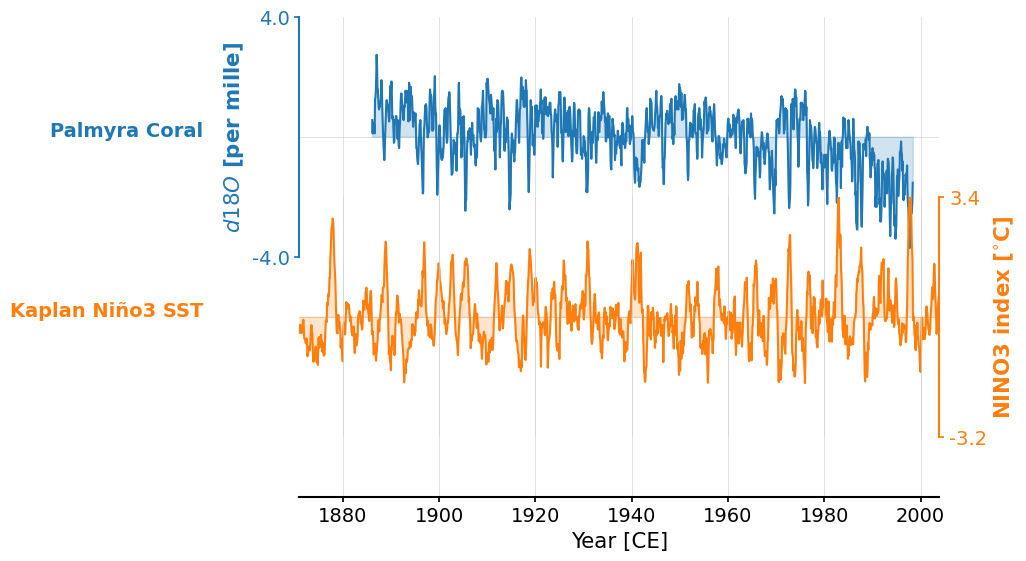

In [ ]:
# Plot the time series
fig, ax = nino.stackplot()

We can also make a warming stripe for this `Series`, where darker red stripes indicate strong positive NINO3 index (i.e., a warmer eastern Pacific and El Nino phase), and darker blue stripes indicate a stronger negative NINO3 index (i.e., a cooler eastern Pacific and La Nina phase).

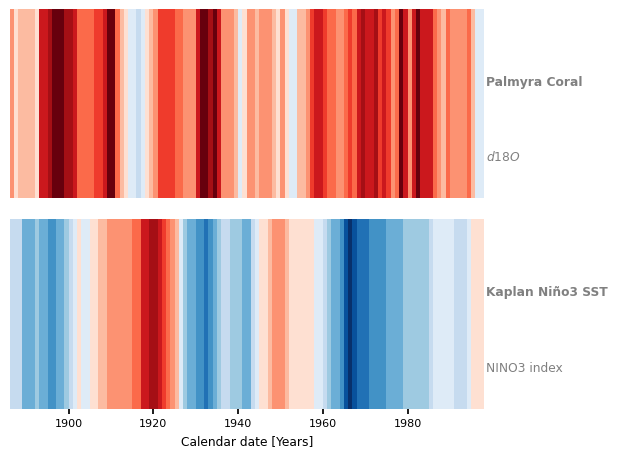

In [ ]:
fig, ax = nino.stripes(ref_period=(1961,1990))

Based on the time series and warming stripe, what do you notice about the changes in SST?


*   When were the strongest El Nino and La Nina during this time period?
*   One what timescale does the ENSO phase vary?
*   Recall that the Kaplan Nino3 SST data is the average SST in the NINO3 region (5°N-5°S, 150°W-190°E) whereas the Palmyra corals are from 6°N, 162°W. Considering this, how can you explain the warming stripes?



